In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install missingno
import missingno as msno

import gc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# pipelines
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
# data preparation
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE

In [4]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [6]:

## Train setine df, test setine apptest dedim.



df = pd.read_csv("../input/home-credit-default-risk/application_train.csv")
apptest = pd.read_csv("../input/home-credit-default-risk/application_test.csv")

In [7]:

#### Test ve train setini birleştirip ön hazırlıkları yaptım.  test setini sildim ve ram 
# gc.collect kullandım



df = df.append(apptest).reset_index()
df = df[df['CODE_GENDER'] != 'XNA']
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()/-365
df['DAYS_EMPLOYED'].replace(365243,np.nan, inplace=True)
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df["INCOME_PER_CHILD"] = df["AMT_INCOME_TOTAL"] / df["CNT_CHILDREN"]
df["INCOME_PER_CHILD"] = df["AMT_INCOME_TOTAL"] / (1 + df["CNT_CHILDREN"])
df['MaasVUrunFiyat'] = df['AMT_INCOME_TOTAL']/ df['AMT_GOODS_PRICE']
df['MaasVsKrediTutari'] =df['AMT_INCOME_TOTAL']/ df['AMT_CREDIT']
df['KrediTutariVsUrunFiyati'] =df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
df['MusteriSkor'] = df['REGION_RATING_CLIENT']*df['REGION_RATING_CLIENT_W_CITY']
df["EMPLOYED_BIRTH_DAYS"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df["DAYS_LAST_PHONE_CHANGE"] = df["DAYS_LAST_PHONE_CHANGE"]/-1
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    #dataframe['NEW_CREDIT_TO_INCOME_RATIO'] = dataframe['AMT_CREDIT'] / dataframe['AMT_INCOME_TOTAL']
df['Industry'] = df['ORGANIZATION_TYPE'].apply(lambda x: x if 'Industry' in x else 'NotIndustry')
df['Business Entity'] = df['ORGANIZATION_TYPE'].apply(lambda x: x if 'Business Entity' in x else 'NotBsiness')
df['Trade'] = df['ORGANIZATION_TYPE'].apply(lambda x: x if 'Trade' in x else 'NotTrade') 
df['Transport'] = df['ORGANIZATION_TYPE'].apply(lambda x: x if 'Transport' in x else 'NotTransport')
df, cat_cols = one_hot_encoder(df, nan_as_category=False)
del apptest
gc.collect()

45

In [8]:
#### credit_card_balance kart için ön hazırlıkları yaptım. tüm kolonları alıp bunların aggragationlarla aldım


### credit_card_balance  prep
cred = pd.read_csv("../input/home-credit-default-risk/credit_card_balance.csv")
cred, cat_cols = one_hot_encoder(cred, nan_as_category= True)
cred.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cred_agg = cred.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cred_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cred_agg.columns.tolist()])
cred_agg['CC_COUNT'] = cred.groupby('SK_ID_CURR').size()
del cred
gc.collect()

0

In [9]:
### cred_agg ana df ile birleştirdim
df = df.join(cred_agg, how='left', on='SK_ID_CURR')

In [10]:
#### pos_cash için 
pos = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
pos_agg = pos.groupby("SK_ID_CURR").agg({'MONTHS_BALANCE': ['max', 'mean', 'size'],
                                          'SK_DPD': ['max', 'mean'],
                                           'SK_DPD_DEF': ['max', 'mean']})
# Agrigation daki birinci ve ikinci bölümlerin isimlerini büyüterek kolona ekledim
pos_agg.columns = pd.Index(['POS' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# işimize yarayacak dataframe pos_agg oldu. pos dataframe'ini çalışmadan çık
del pos
gc.collect()

23

In [11]:
## pos_agg yi ana veriye ekledim.
df = df.join(pos_agg, how='left', on='SK_ID_CURR')

In [12]:
inst = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')
inst, cat_cols = one_hot_encoder(inst, nan_as_category= True)
inst["PAYMENT_RATE"] = inst["AMT_PAYMENT"] / inst["AMT_INSTALMENT"]
# taksit ödemesi - ödenen ücret
inst["PAYMENT_DIFF"] = inst["AMT_INSTALMENT"] - inst["AMT_PAYMENT"]

# V_G vadesi geçen gün sayısı, V_O Son ödemesine kalan gün sayısı
inst['V_G'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['V_O'] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']

# Negatif değer yerine optimize etmiş gibi sıfır koysak?
inst['V_G'] = inst['V_G'].apply(lambda x: x if x > 0 else 0)
inst['V_O'] = inst['V_O'].apply(lambda x: x if x > 0 else 0)

#Her bir taksitte ödenen miktar
inst["PER_PAYMENT_NUMBER"] = inst["AMT_PAYMENT"] / inst["NUM_INSTALMENT_NUMBER"]

### Taksit sayısıyla, vadesinden önce ödeme oranı arasında negatif bir korelasyon var.
# Taksit sayısı arttıkça, vadesinden önce ödeme düşüyor.

# Aynı işlemleri inst için de yaptım ve inst dataframe silebiliriz.
inst_agg = inst.groupby("SK_ID_CURR").agg({'PER_PAYMENT_NUMBER': ['max', 'mean', 'size'],
                                                'V_O': ['max', 'mean'],
                                                 'V_G': ['max', 'mean'],
                                                 'PAYMENT_DIFF': ['max', 'mean'],
                                                 'PAYMENT_RATE': ['max', 'mean'],
                                           })
inst_agg.columns = pd.Index(['INST' + e[0] + "_" + e[1].upper() for e in inst_agg.columns.tolist()])

del inst
gc.collect()

0

In [13]:
df = df.join(inst_agg, how='left', on='SK_ID_CURR')

In [14]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
   
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    cat_cols = [col for col in cat_cols if col not in "TARGET"]
    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]                                              
    num_cols = [col for col in num_cols if col not in "index"] 
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 356251
Variables: 443
cat_cols: 235
num_cols: 205
cat_but_car: 0
num_but_cat: 236


In [16]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [17]:
df["GOOD_EXIT_MEAN_DIVIDE"] = df["AMT_GOODS_PRICE"] / df["NEW_EXT_SOURCES_MEAN"]
df["GOOD_EXIT_MEAN_CROSS"] = df["AMT_GOODS_PRICE"] * df["NEW_EXT_SOURCES_MEAN"]
df["EXIT_BIRTH_DIVIDE"] = df["DAYS_BIRTH"] / df["EXT_SOURCE_3"]
df["EXIT_BIRTH_CROS"] = df["DAYS_BIRTH"] * df["EXT_SOURCE_3"]
df["GOOD_EXIT_MEAN_DIVIDE_BIRTH_CROS"] = df["GOOD_EXIT_MEAN_DIVIDE"] / df["EXT_SOURCE_3"]
df["DAYS_EXT_DIVIDE"] = df["DAYS_BIRTH"] / df["NEW_EXT_SOURCES_MEAN"]
df["DAYS_EXT_CROSS"] = df["DAYS_BIRTH"] * df["NEW_EXT_SOURCES_MEAN"]
df["DAYS_SOURCE_2_DIVIDE"] = df["DAYS_ID_PUBLISH"] / df["EXT_SOURCE_2"]
df["DAYS_SOURCE_2_CROSS"] = df["DAYS_ID_PUBLISH"] * df["EXT_SOURCE_2"]
df["G_E_DIVIDE"] = df["GOOD_EXIT_MEAN_DIVIDE"] / df["EXIT_BIRTH_DIVIDE"]
df["D_D_CROSS"] = df["DAYS_EXT_CROSS"] * df["DAYS_SOURCE_2_DIVIDE"]
df["D_D_DIVIDE"] = df["DAYS_EXT_DIVIDE"] / df["DAYS_SOURCE_2_DIVIDE"]
df["1"] = df["DAYS_EXT_DIVIDE"] / df["GOOD_EXIT_MEAN_DIVIDE"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 356251
Variables: 456
cat_cols: 235
num_cols: 218
cat_but_car: 0
num_but_cat: 236


In [19]:
# en son dataframe


import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [20]:
#X_scaled = StandardScaler().fit_transform(df[num_cols])
#df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [21]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [22]:
y = train_df["TARGET"]
X = train_df.drop(["TARGET",'SK_ID_CURR','index'], axis=1)

In [23]:
train_df["TARGET"].value_counts()

0.000    282682
1.000     24825
Name: TARGET, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


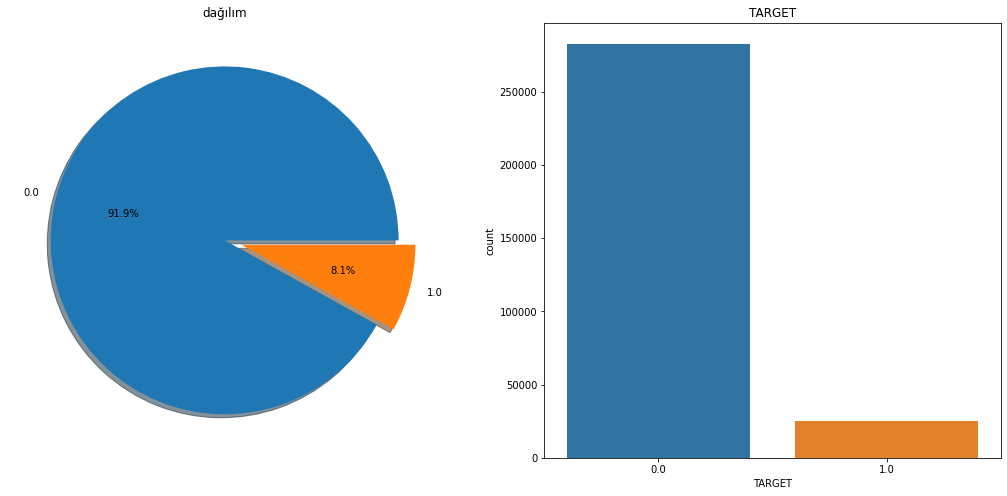

In [24]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['TARGET'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('dağılım')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=df,ax=ax[1])
ax[1].set_title('TARGET')
plt.show()

In [25]:
from imblearn.under_sampling import RandomUnderSampler
# transform the dataset
ranUnSample = RandomUnderSampler()
X_ranUnSample, y_ranUnSample = ranUnSample.fit_resample(X, y)

In [26]:
lgbm_final_model = LGBMClassifier(random_state=17).fit(X_ranUnSample, y_ranUnSample)

cv_results = cross_validate(lgbm_final_model, X_ranUnSample, y_ranUnSample, cv=5, scoring=["roc_auc"])

cv_results['test_roc_auc'].mean()

0.7668086109310998

In [28]:
import pickle
file =open("final_model.pkl","wb")
pickle.dump(lgbm_final_model, file)

In [ ]:
#rom pickle  import dumb
#umb(lgbm_final_model, open("final_model.pkl","wb"))


In [ ]:
#lgbm_final_model = LGBMClassifier(random_state=17, max_bin=255, n_estimators=12000, colsample_bytree=0.9, learning_rate=0.01).fit(X_ranUnSample, y_ranUnSample)

#cv_results = cross_validate(lgbm_final_model, X_ranUnSample, y_ranUnSample, cv=5, scoring=["roc_auc"])

#cv_results['test_roc_auc'].mean()

0.7609245382328871

In [ ]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr)
    plt.show()
    pass

#generate_auc_roc_curve(lgbm_model, X_test)

In [ ]:
y_t = test_df['TARGET']
X_t = test_df.drop(["TARGET",'SK_ID_CURR','index'], axis=1)
y_pred= lgbm_final_model.predict(X_t)
my_submission = pd.DataFrame({'SK_ID_CURR': test_df.SK_ID_CURR, 'TARGET': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission8_max_bin_with_features.csv', index=False)

In [ ]:

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    
    
    plt.figure(figsize=(10, 50))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    
    return

In [ ]:
plot_importance(lgbm_final_model, X_ranUnSample)

In [ ]:
#pd.DataFrame(y_pred).value_counts()